<a href="https://colab.research.google.com/github/Yasir323/100-days-of-code/blob/master/Concurrency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference
1. <a href="https://realpython.com/python-concurrency/">Real Python - Speed Up Your Python Program With Concurrency</a>
2. <a href="https://krondo.com/in-which-we-begin-at-the-beginning/">In Which We Begin at the Beginning</a>

## What Is Concurrency?

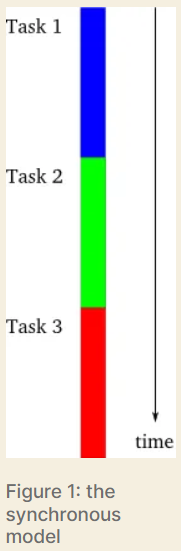

The dictionary definition of *concurrency is simultaneous occurrence*. In Python, the things that are occurring simultaneously are called by different names (thread, task, process) but at a high level, they all refer to a sequence of instructions that run in order.

I like to think of them as different trains of thought. Each one can be stopped at certain points, and the CPU or brain that is processing them can switch to a different one. The state of each one is saved so it can be restarted right where it was interrupted.

You might wonder why Python uses different words for the same concept. It turns out that threads, tasks, and processes are only the same if you view them from a high level. Once you start digging into the details, they all represent slightly different things. You’ll see more of how they are different as you progress through the examples.

Now let’s talk about the simultaneous part of that definition. You have to be a little careful because, when you get down to the details, *only multiprocessing actually runs these trains of thought at literally the same time. Threading and asyncio both run on a single processor and therefore only run one at a time. They just cleverly find ways to take turns to speed up the overall process. Even though they don’t run different trains of thought simultaneously, we still call this concurrency.*

The way the threads or tasks take turns is the big difference between threading and asyncio. *In threading, the operating system actually knows about each thread and can interrupt it at any time to start running a different thread. This is called **pre-emptive multitasking** since the operating system can pre-empt your thread to make the switch*.

Pre-emptive multitasking is handy in that the code in the thread doesn’t need to do anything to make the switch. It can also be difficult because of that “at any time” phrase. This switch can happen in the middle of a single Python statement, even a trivial one like x = x + 1.

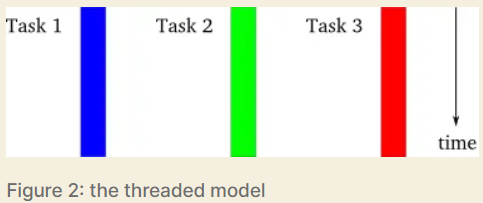

*Asyncio, on the other hand, uses **cooperative multitasking**. The tasks must cooperate by announcing when they are ready to be switched out. That means that the code in the task has to change slightly to make this happen*.

The benefit of doing this extra work up front is that you always know where your task will be swapped out. It will not be swapped out in the middle of a Python statement unless that statement is marked. You’ll see later how this can simplify parts of your design.

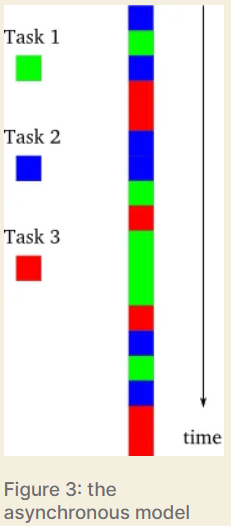

## What Is Parallelism?

So far, you’ve looked at concurrency that happens on a single processor. What about all of those CPU cores your cool, new laptop has? How can you make use of them? multiprocessing is the answer.

With multiprocessing, Python creates new processes. A process here can be thought of as almost a completely different program, though technically they’re usually defined as a collection of resources where the resources include memory, file handles and things like that. One way to think about it is that each process runs in its own Python interpreter.

Because they are different processes, each of your trains of thought in a multiprocessing program can run on a different core. Running on a different core means that they actually can run at the same time, which is fabulous. There are some complications that arise from doing this, but Python does a pretty good job of smoothing them over most of the time.

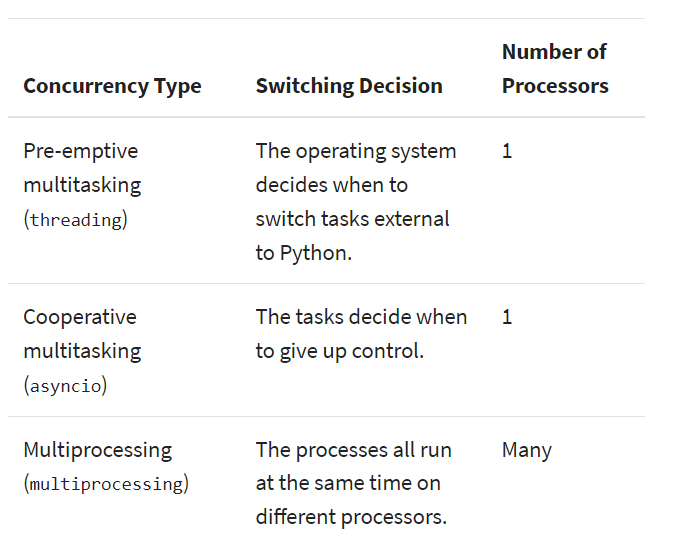

## When Is Concurrency Useful?

Concurrency can make a big difference for two types of problems. These are generally called **CPU-bound** and **I/O-bound**.

I/O-bound problems cause your program to slow down because it frequently must wait for input/output (I/O) from some external resource. They arise frequently when your program is working with things that are much slower than your CPU.

Examples of things that are slower than your CPU are legion, but your program thankfully does not interact with most of them. The slow things your program will interact with most frequently are the file system and network connections.

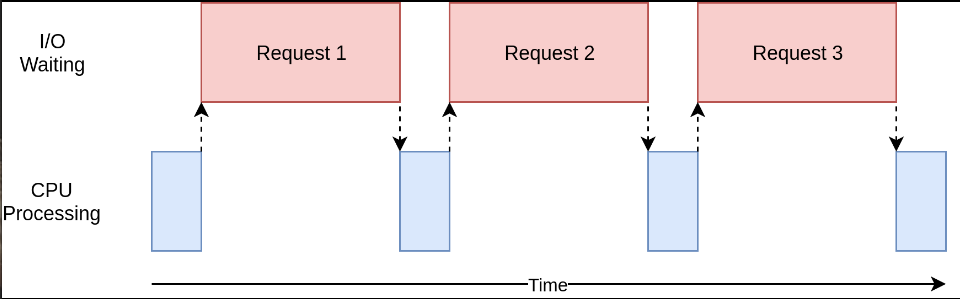

In the diagram above, the blue boxes show time when your program is doing work, and the red boxes are time spent waiting for an I/O operation to complete. This diagram is not to scale because requests on the internet can take several orders of magnitude longer than CPU instructions, so your program can end up spending most of its time waiting. This is what your browser is doing most of the time.

On the flip side, there are classes of programs that do significant computation without talking to the network or accessing a file. These are the CPU-bound programs, because the resource limiting the speed of your program is the CPU, not the network or the file system.

Here’s a corresponding diagram for a CPU-bound program:

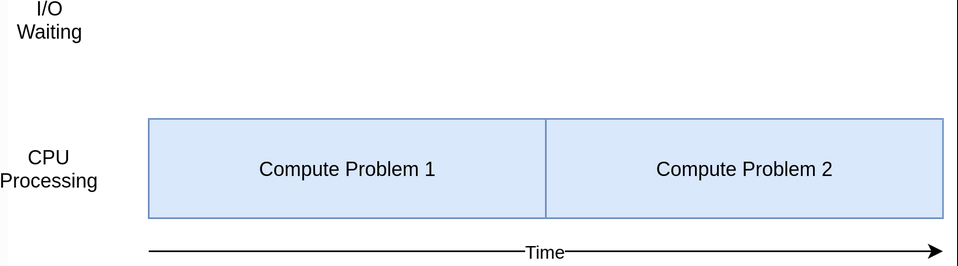

Different forms of concurrency work better or worse with CPU-bound and I/O-bound programs. Adding concurrency to your program adds extra code and complications, so you’ll need to decide if the potential speed up is worth the extra effort.

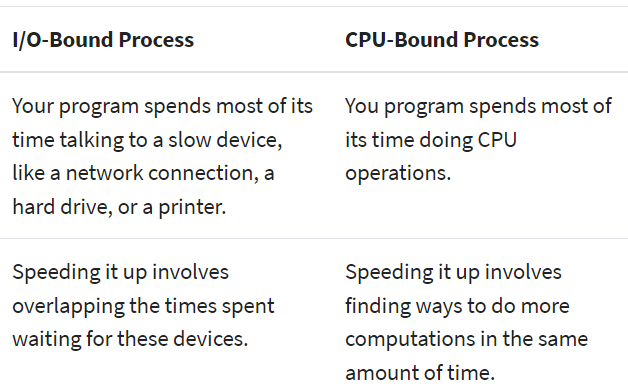

## How to Speed Up an I/O-Bound Program

### Synchronous Version

In [1]:
import requests
import time

In [2]:
def download_site(url, session):
    with session.get(url) as response:
        print(f"Read {len(response.content)} from {url}")

In [3]:
def download_all_sites(sites):
    with requests.Session() as session:
        for url in sites:
            download_site(url, session)

In [4]:
sites = [
    "https://www.jython.org",
    "http://olympus.realpython.org/dice",
] * 80
start_time = time.time()
download_all_sites(sites)
duration = time.time() - start_time
print(f"Downloaded {len(sites)} in {duration} seconds")

Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jyth

As you can see, this is a fairly short program. download_site() just downloads the contents from a URL and prints the size. One small thing to point out is that we’re using a Session object from requests.

It is possible to simply use get() from requests directly, but creating a Session object allows requests to do some fancy networking tricks and really speed things up.

#### Why the Synchronous Version Rocks

The great thing about this version of code is that, well, it’s easy. It was comparatively easy to write and debug. It’s also more straight-forward to think about. There’s only one train of thought running through it, so you can predict what the next step is and how it will behave.

#### The Problems With the Synchronous Version

The big problem here is that it’s relatively slow compared to the other solutions we’ll provide.

Being slower isn’t always a big issue, however. If the program you’re running takes only 2 seconds with a synchronous version and is only run rarely, it’s probably not worth adding concurrency. You can stop here.

What if your program is run frequently? What if it takes hours to run? Let’s move on to concurrency by rewriting this program using threading.

### threading Version

In [5]:
import concurrent.futures
import threading

In [6]:
thread_local = threading.local()

In [7]:
def get_session():
    if not hasattr(thread_local, "session"):
        thread_local.session = requests.Session()
    return thread_local.session

In [8]:
def download_site(url):
    session = get_session()
    with session.get(url) as response:
        print(f"Read {len(response.content)} from {url}")

In [9]:
def download_all_sites(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_site, sites)

In [10]:
sites = [
    "https://www.jython.org",
    "http://olympus.realpython.org/dice",
] * 80
start_time = time.time()
download_all_sites(sites)
duration = time.time() - start_time
print(f"Downloaded {len(sites)} in {duration} seconds")

Read 10490 from https://www.jython.org
Read 10490 from https://www.jython.org
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 277 from http://olympus.realpython.org/dice
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 277 from http://olympus.realpython.org/dice
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 277 from http://olympus.realpython.org/dice
Read 10490 from https://www.jython.org
Read 10490 from https://www.jyth

When you add threading, the overall structure is the same and you only needed to make a few changes. download_all_sites() changed from calling the function once per site to a more complex structure.

In this version, you’re creating a ThreadPoolExecutor, which seems like a complicated thing. Let’s break that down: ThreadPoolExecutor = Thread + Pool + Executor.

You already know about the Thread part. That’s just a train of thought we mentioned earlier. The Pool portion is where it starts to get interesting. This object is going to create a pool of threads, each of which can run concurrently. Finally, the Executor is the part that’s going to control how and when each of the threads in the pool will run. It will execute the request in the pool.

Helpfully, the standard library implements ThreadPoolExecutor as a context manager so you can use the with syntax to manage creating and freeing the pool of Threads.

Once you have a ThreadPoolExecutor, you can use its handy .map() method. This method runs the passed-in function on each of the sites in the list. The great part is that it automatically runs them concurrently using the pool of threads it is managing.

Those of you coming from other languages, or even Python 2, are probably wondering where the usual objects and functions are that manage the details you’re used to when dealing with threading, things like Thread.start(), Thread.join(), and Queue.

These are all still there, and you can use them to achieve fine-grained control of how your threads are run. But, starting with Python 3.2, the standard library added a higher-level abstraction called Executors that manage many of the details for you if you don’t need that fine-grained control.

The other interesting change in our example is that each thread needs to create its own requests.Session() object. When you’re looking at the documentation for requests, it’s not necessarily easy to tell, but reading this issue, it seems fairly clear that you need a separate Session for each thread.

This is one of the interesting and difficult issues with threading. Because the operating system is in control of when your task gets interrupted and another task starts, any data that is shared between the threads needs to be protected, or thread-safe. Unfortunately requests.Session() is not thread-safe.

There are several strategies for making data accesses thread-safe depending on what the data is and how you’re using it. One of them is to use thread-safe data structures like Queue from Python’s queue module.

These objects use low-level primitives like threading.Lock to ensure that only one thread can access a block of code or a bit of memory at the same time. You are using this strategy indirectly by way of the ThreadPoolExecutor object.

Another strategy to use here is something called thread local storage. threading.local() creates an object that looks like a global but is specific to each individual thread. In your example, this is done with thread_local and get_session().

local() is in the threading module to specifically solve this problem. It looks a little odd, but you only want to create one of these objects, not one for each thread. The object itself takes care of separating accesses from different threads to different data.

When get_session() is called, the session it looks up is specific to the particular thread on which it’s running. So each thread will create a single session the first time it calls get_session() and then will simply use that session on each subsequent call throughout its lifetime.

The difficult answer here is that the correct number of threads is not a constant from one task to another. Some experimentation is required.

#### Why the threading Version Rocks?
It’s fast! It uses multiple threads to have multiple open requests out to web sites at the same time, allowing your program to overlap the waiting times and get the final result faster!

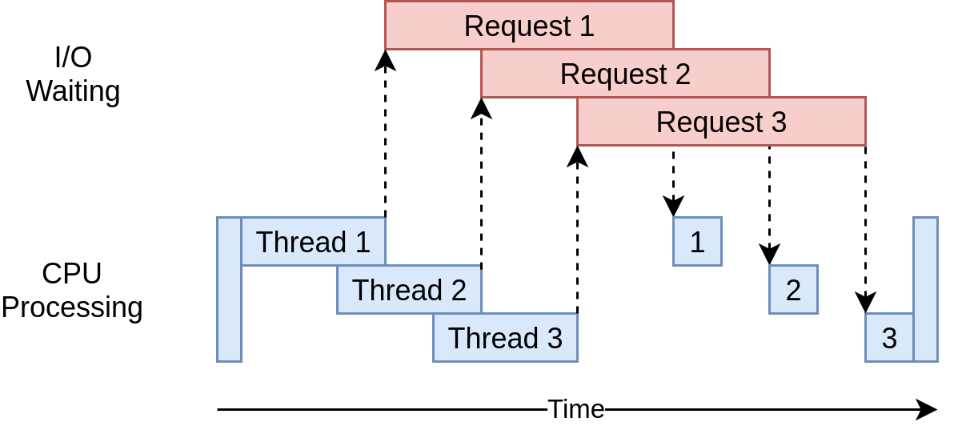

#### The Problems with the threading Version

Well, as you can see from the example, it takes a little more code to make this happen, and you really have to give some thought to what data is shared between threads.

Threads can interact in ways that are subtle and hard to detect. These interactions can cause race conditions that frequently result in random, intermittent bugs that can be quite difficult to find.

### asyncio Version
Before you jump into examining the asyncio example code, let’s talk more about how asyncio works.

asyncio Basics

This will be a simplified version of asyncio. There are many details that are glossed over here, but it still conveys the idea of how it works.

The general concept of asyncio is that a single Python object, called the event loop, controls how and when each task gets run. The event loop is aware of each task and knows what state it’s in. In reality, there are many states that tasks could be in, but for now let’s imagine a simplified event loop that just has two states.

The ready state will indicate that a task has work to do and is ready to be run, and the waiting state means that the task is waiting for some external thing to finish, such as a network operation.

Your simplified event loop maintains two lists of tasks, one for each of these states. It selects one of the ready tasks and starts it back to running. That task is in complete control until it cooperatively hands the control back to the event loop.

When the running task gives control back to the event loop, the event loop places that task into either the ready or waiting list and then goes through each of the tasks in the waiting list to see if it has become ready by an I/O operation completing. It knows that the tasks in the ready list are still ready because it knows they haven’t run yet.

Once all of the tasks have been sorted into the right list again, the event loop picks the next task to run, and the process repeats. Your simplified event loop picks the task that has been waiting the longest and runs that. This process repeats until the event loop is finished.

An important point of asyncio is that the tasks never give up control without intentionally doing so. They never get interrupted in the middle of an operation. This allows us to share resources a bit more easily in asyncio than in threading. You don’t have to worry about making your code thread-safe.

That’s a high-level view of what’s happening with asyncio. If you want more detail, this <a href="https://stackoverflow.com/a/51116910/6843734">StackOverflow</a> answer provides some good details if you want to dig deeper.

async and await

Now let’s talk about two new keywords that were added to Python: async and await. In light of the discussion above, you can view await as the magic that allows the task to hand control back to the event loop. When your code awaits a function call, it’s a signal that the call is likely to be something that takes a while and that the task should give up control.

It’s easiest to think of async as a flag to Python telling it that the function about to be defined uses await. There are some cases where this is not strictly true, like asynchronous generators, but it holds for many cases and gives you a simple model while you’re getting started.

One exception to this that you’ll see in the next code is the async with statement, which creates a context manager from an object you would normally await. While the semantics are a little different, the idea is the same: to flag this context manager as something that can get swapped out.

As I’m sure you can imagine, there’s some complexity in managing the interaction between the event loop and the tasks. For developers starting out with asyncio, these details aren’t important, but you do need to remember that any function that calls await needs to be marked with async. You’ll get a syntax error otherwise.

In [11]:
!pip install -U aiohttp

In [12]:
import asyncio
import aiohttp

In [13]:
async def download_site(session, url):
    async with session.get(url) as response:
        print("Read {0} from {1}".format(response.content_length, url))

download_site() at the top is almost identical to the threading version with the exception of the async keyword on the function definition line and the async with keywords when you actually call session.get(). You’ll see later why Session can be passed in here rather than using thread-local storage.

In [14]:
async def download_all_sites(sites):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for url in sites:
            task = asyncio.ensure_future(download_site(session, url))
            tasks.append(task)
        await asyncio.gather(*tasks, return_exceptions=True)

download_all_sites() is where you will see the biggest change from the threading example.

You can share the session across all tasks, so the session is created here as a context manager. The tasks can share the session because they are all running on the same thread. There is no way one task could interrupt another while the session is in a bad state.

Inside that context manager, it creates a list of tasks using asyncio.ensure_future(), which also takes care of starting them. Once all the tasks are created, this function uses asyncio.gather() to keep the session context alive until all of the tasks have completed.

The threading code does something similar to this, but the details are conveniently handled in the ThreadPoolExecutor. There currently is not an AsyncioPoolExecutor class.

There is one small but important change buried in the details here, however. Remember how we talked about the number of threads to create? It wasn’t obvious in the threading example what the optimal number of threads was.

One of the cool advantages of asyncio is that it scales far better than threading. Each task takes far fewer resources and less time to create than a thread, so creating and running more of them works well. This example just creates a separate task for each site to download, which works out quite well.

In [16]:
# sites = [
#     "https://www.jython.org",
#     "http://olympus.realpython.org/dice",
# ] * 80
# start_time = time.time()
# asyncio.run(download_all_sites(sites))
# duration = time.time() - start_time
# print(f"Downloaded {len(sites)} sites in {duration} seconds")

In [17]:
#RUN THIS IN A SCRIPT

Finally, the nature of asyncio means that you have to start up the event loop and tell it which tasks to run. The __main__ section at the bottom of the file contains the code to get_event_loop() and then run_until_complete(). If nothing else, they’ve done an excellent job in naming those functions.

If you’ve updated to Python 3.7, the Python core developers simplified this syntax for you. Instead of the asyncio.get_event_loop().run_until_complete() tongue-twister, you can just use asyncio.run().

#### Why the asyncio Version Rocks?

It’s really fast! The execution timing diagram looks quite similar to what’s happening in the threading example. It’s just that the I/O requests are all done by the same thread:
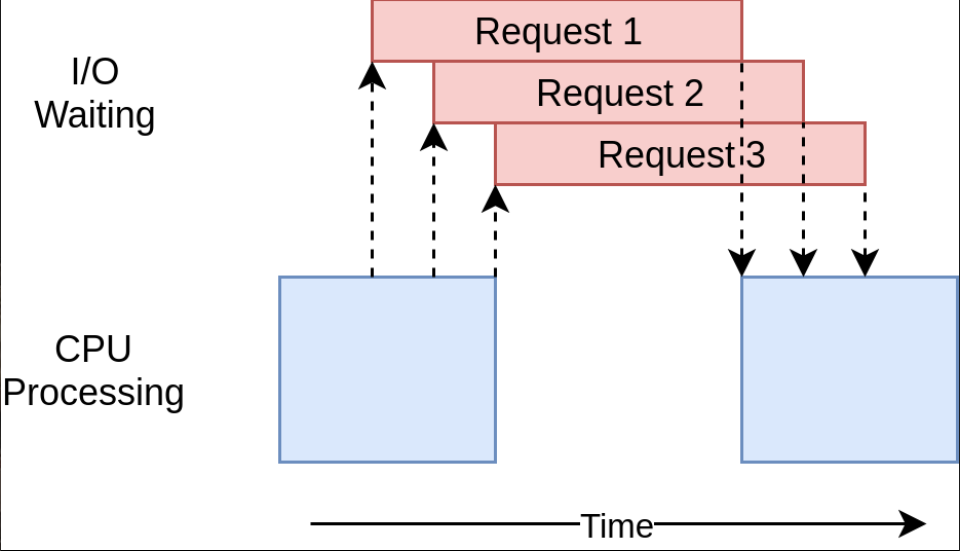

The lack of a nice wrapper like the ThreadPoolExecutor makes this code a bit more complex than the threading example. This is a case where you have to do a little extra work to get much better performance.

Also there’s a common argument that having to add async and await in the proper locations is an extra complication. To a small extent, that is true. The flip side of this argument is that it forces you to think about when a given task will get swapped out, which can help you create a better, faster, design.

The scaling issue also looms large here. Running the threading example above with a thread for each site is noticeably slower than running it with a handful of threads. Running the asyncio example with hundreds of tasks didn’t slow it down at all.

#### The Problems With the asyncio Version

There are a couple of issues with asyncio at this point. You need special async versions of libraries to gain the full advantage of asyncio. Had you just used requests for downloading the sites, it would have been much slower because requests is not designed to notify the event loop that it’s blocked. This issue is getting smaller and smaller as time goes on and more libraries embrace asyncio.

Another, more subtle, issue is that all of the advantages of cooperative multitasking get thrown away if one of the tasks doesn’t cooperate. A minor mistake in code can cause a task to run off and hold the processor for a long time, starving other tasks that need running. There is no way for the event loop to break in if a task does not hand control back to it.

### Multi-processing Version
Up until this point, all of the examples of concurrency in this article run only on a single CPU or core in your computer. The reasons for this have to do with the current design of CPython and something called the Global Interpreter Lock, or GIL.

This article won’t dive into the hows and whys of the GIL. It’s enough for now to know that the synchronous, threading, and asyncio versions of this example all run on a single CPU.

multiprocessing in the standard library was designed to break down that barrier and run your code across multiple CPUs. At a high level, it does this by creating a new instance of the Python interpreter to run on each CPU and then farming out part of your program to run on it.

As you can imagine, bringing up a separate Python interpreter is not as fast as starting a new thread in the current Python interpreter. It’s a heavyweight operation and comes with some restrictions and difficulties, but for the correct problem, it can make a huge difference.

In [18]:
import multiprocessing

In [19]:
session = None

In [20]:
def set_global_session():
    global session
    if not session:
        session = requests.Session()

In [21]:
def download_site(url):
    with session.get(url) as response:
        name = multiprocessing.current_process().name
        print(f"{name}:Read {len(response.content)} from {url}")

In [24]:
def download_all_sites(sites):
    with multiprocessing.Pool(initializer=set_global_session) as pool:
        pool.map(download_site, sites)

What happens here is that the Pool creates a number of separate Python interpreter processes and has each one run the specified function on some of the items in the iterable, which in our case is the list of sites. The communication between the main process and the other processes is handled by the multiprocessing module for you.

The line that creates Pool is worth your attention. First off, it does not specify how many processes to create in the Pool, although that is an optional parameter. By default, multiprocessing.Pool() will determine the number of CPUs in your computer and match that. This is frequently the best answer, and it is in our case.

For this problem, increasing the number of processes did not make things faster. It actually slowed things down because the cost for setting up and tearing down all those processes was larger than the benefit of doing the I/O requests in parallel.

Next we have the initializer=set_global_session part of that call. Remember that each process in our Pool has its own memory space. That means that they cannot share things like a Session object. You don’t want to create a new Session each time the function is called, you want to create one for each process.

The initializer function parameter is built for just this case. There is not a way to pass a return value back from the initializer to the function called by the process download_site(), but you can initialize a global session variable to hold the single session for each process. Because each process has its own memory space, the global for each one will be different.

In [23]:
sites = [
    "https://www.jython.org",
    "http://olympus.realpython.org/dice",
] * 80
start_time = time.time()
download_all_sites(sites)
duration = time.time() - start_time
print(f"Downloaded {len(sites)} in {duration} seconds")

ForkPoolWorker-1:Read 10490 from https://www.jython.org
ForkPoolWorker-2:Read 10490 from https://www.jython.org
ForkPoolWorker-1:Read 277 from http://olympus.realpython.org/dice
ForkPoolWorker-2:Read 277 from http://olympus.realpython.org/dice
ForkPoolWorker-1:Read 10490 from https://www.jython.org
ForkPoolWorker-2:Read 10490 from https://www.jython.org
ForkPoolWorker-1:Read 277 from http://olympus.realpython.org/dice
ForkPoolWorker-2:Read 277 from http://olympus.realpython.org/dice
ForkPoolWorker-1:Read 10490 from https://www.jython.org
ForkPoolWorker-2:Read 10490 from https://www.jython.org
ForkPoolWorker-1:Read 277 from http://olympus.realpython.org/dice
ForkPoolWorker-2:Read 277 from http://olympus.realpython.org/dice
ForkPoolWorker-1:Read 10490 from https://www.jython.org
ForkPoolWorker-2:Read 10490 from https://www.jython.org
ForkPoolWorker-1:Read 277 from http://olympus.realpython.org/dice
ForkPoolWorker-1:Read 10490 from https://www.jython.org
ForkPoolWorker-2:Read 277 from htt

#### Why the multiprocessing Version Rocks

The multiprocessing version of this example is great because it’s relatively easy to set up and requires little extra code. It also takes full advantage of the CPU power in your computer. The execution timing diagram for this code looks like this:

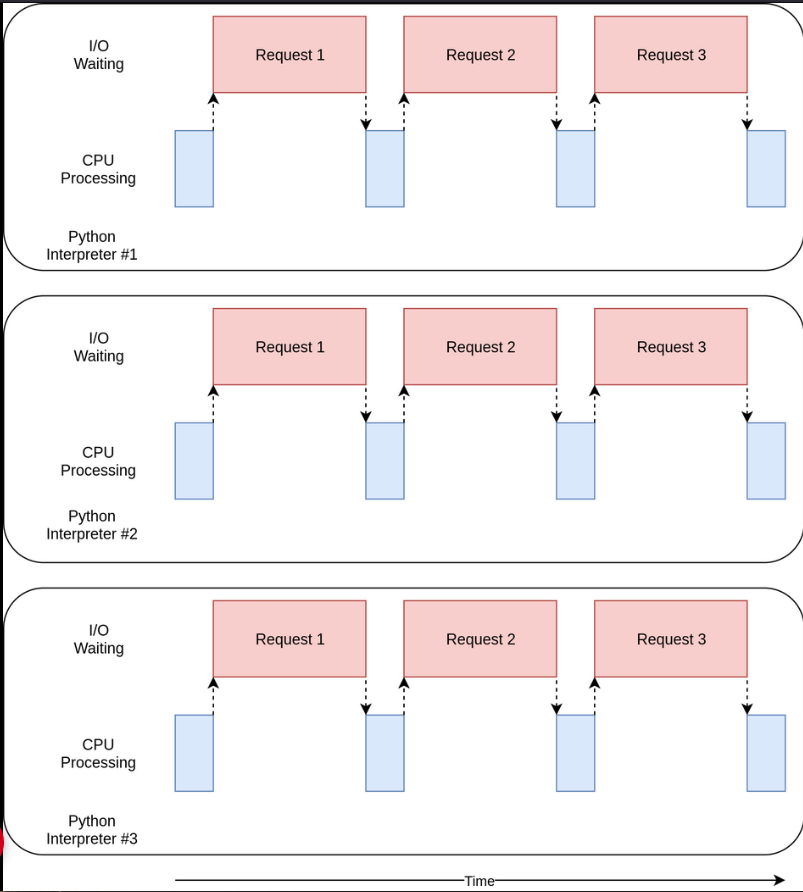

#### The Problems With the multiprocessing Version

This version of the example does require some extra setup, and the global session object is strange. You have to spend some time thinking about which variables will be accessed in each process.

## How to Speed Up a CPU-Bound Program


In [25]:
def cpu_bound(number):
    return sum(i * i for i in range(number))

In [26]:
def find_sums(numbers):
    for number in numbers:
        cpu_bound(number)

In [27]:
numbers = [5_000_000 + x for x in range(20)]

start_time = time.time()
find_sums(numbers)
duration = time.time() - start_time
print(f"Duration {duration} seconds")

Duration 11.308934211730957 seconds


This code calls cpu_bound() 20 times with a different large number each time. It does all of this on a single thread in a single process on a single CPU. The execution timing diagram looks like this:
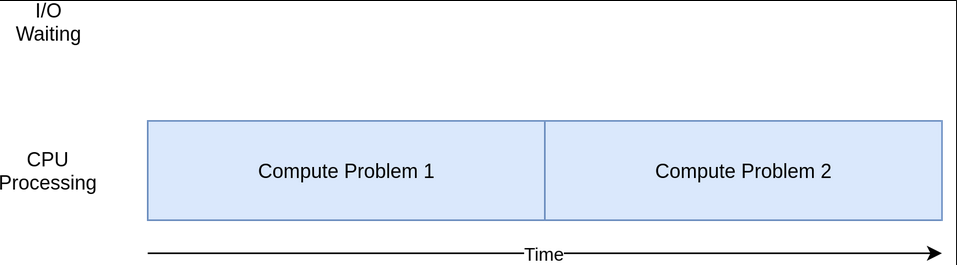

### threading and asyncio Versions

How much do you think rewriting this code using threading or asyncio will speed this up?

If you answered “Not at all,” give yourself a cookie. If you answered, “It will slow it down,” give yourself two cookies.

Here’s why: In your I/O-bound example above, much of the overall time was spent waiting for slow operations to finish. threading and asyncio sped this up by allowing you to overlap the times you were waiting instead of doing them sequentially.

On a CPU-bound problem, however, there is no waiting. The CPU is cranking away as fast as it can to finish the problem. In Python, both threads and tasks run on the same CPU in the same process. That means that the one CPU is doing all of the work of the non-concurrent code plus the extra work of setting up threads or tasks.

In [28]:
def find_sums(numbers):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(cpu_bound, numbers)

In [29]:
numbers = [5_000_000 + x for x in range(20)]

start_time = time.time()
find_sums(numbers)
duration = time.time() - start_time
print(f"Duration {duration} seconds")

Duration 11.434738874435425 seconds


CPU-Bound multiprocessing Version

Now you’ve finally reached where multiprocessing really shines. Unlike the other concurrency libraries, multiprocessing is explicitly designed to share heavy CPU workloads across multiple CPUs. Here’s what its execution timing diagram looks like:
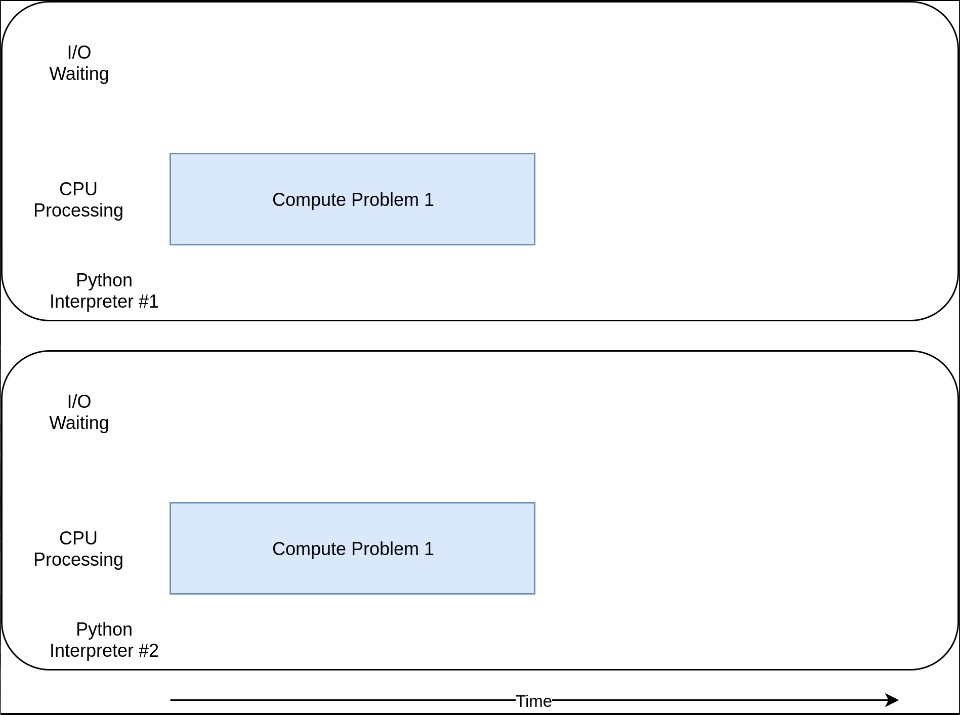

In [30]:
def find_sums(numbers):
    with multiprocessing.Pool() as pool:
        pool.map(cpu_bound, numbers)

In [32]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [31]:
numbers = [5_000_000 + x for x in range(20)]

start_time = time.time()
find_sums(numbers)
duration = time.time() - start_time
print(f"Duration {duration} seconds")

Duration 12.34923267364502 seconds


#### Why the multiprocessing Version Rocks

The multiprocessing version of this example is great because it’s relatively easy to set up and requires little extra code. It also takes full advantage of the CPU power in your computer.

#### The Problems With the multiprocessing Version

There are some drawbacks to using multiprocessing. They don’t really show up in this simple example, but splitting your problem up so each processor can work independently can sometimes be difficult.

Also, many solutions require more communication between the processes. This can add some complexity to your solution that a non-concurrent program would not need to deal with.

## When to Use Concurrency

You’ve covered a lot of ground here, so let’s review some of the key ideas and then discuss some decision points that will help you determine which, if any, concurrency module you want to use in your project.

The first step of this process is deciding if you should use a concurrency module. While the examples here make each of the libraries look pretty simple, concurrency always comes with extra complexity and can often result in bugs that are difficult to find.

Hold out on adding concurrency until you have a known performance issue and then determine which type of concurrency you need. As Donald Knuth has said, “Premature optimization is the root of all evil (or at least most of it) in programming.”

Once you’ve decided that you should optimize your program, figuring out if your program is CPU-bound or I/O-bound is a great next step. Remember that I/O-bound programs are those that spend most of their time waiting for something to happen while CPU-bound programs spend their time processing data or crunching numbers as fast as they can.

As you saw, CPU-bound problems only really gain from using multiprocessing. threading and asyncio did not help this type of problem at all.

For I/O-bound problems, there’s a general rule of thumb in the Python community: “Use asyncio when you can, threading when you must.” asyncio can provide the best speed up for this type of program, but sometimes you will require critical libraries that have not been ported to take advantage of asyncio. Remember that any task that doesn’t give up control to the event loop will block all of the other tasks.